# Ch 9 Multi-Agent Reinforcement Learning

##### Listing 9.3

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

def init_grid(size=(10,)):
    # if size=(a,b) -> grid = torch.randn(a,b)
    grid = torch.randn(*size)
    # 절반은 1 절반은 0
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte() #A  그것들을 모아 하나의 바이트로 만듦 
    return grid

def get_reward(s,a): #B  s: 이진수 목록, a: 이진수 하나
    r = -1
    # a와 같으면 보상이 증가됨 
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    # 양옆이 같으면 1.6, 하나만 같으면 -0.2, 모두 다르면 -2.0
    return r

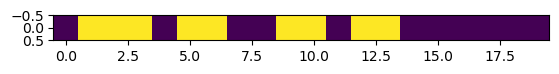

In [2]:
size = (20,)
grid = init_grid(size=size)
# imshow()는 행렬이나 3차원 텐서만 지원 -> expand_dims()함수를 사용해서 벡터에 단일항 차원 추가 
plt.imshow(np.expand_dims(grid,0))

##### Listing 9.4

In [3]:
# 신경망에 사용되는 매개변수 생성 
def gen_params(N,size): #A
    ret = []
    for i in range(N):
        vec = torch.randn(size) / 10.
        vec.requires_grad = True
        ret.append(vec)
    return ret


##### Listing 9.5

In [4]:
# 1차원 이징 모형은 간단해서 pytorch를 사용하지 않고도 쉽게 구현 가능 
def qfunc(s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
    # q function은 [a,b]를 return 하는데 이 것은 아래스핀으로 바꾸면 a, 위스핀으로 바꾸면 b 보상을 받음을 의미 
    l1n = layers[0]  # l1n = (4,20)
    l1s = np.prod(l1n) #A  # l1s=4*20 = 80 
    theta_1 = theta[0:l1s].reshape(l1n) #B  1층의 필요한 매개변수만큼 뽑아서 모양을 만들어줌 

    # 2층도 마찬가지 
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l2s+l1s].reshape(l2n)

    bias = torch.ones((1,theta_1.shape[1]))  # bias=1로 채워진 (1,20)  왜 1로 초기화할까? 
    l1 = s @ theta_1 + bias #C  s: 결합동작 벡터 
    l1 = torch.nn.functional.elu(l1)  # 1층은 elu 함수를 activation으로 사용 
    l2 = afn(l1 @ theta_2) #D  afn:= activation function
    # activation function이 tanh 이므로 [-2,+2] 인 보상은 -1~+1에 가깝게 된다 
    return l2.flatten()  

##### Listing 9.6

In [5]:
# 하나의 이진수를 one-hot encoding 
def get_substate(b): #A
    s = torch.zeros(2)  # s = (0,0)
    if b > 0: #B
        s[1] = 1  # s = (0,1)
    else:
        s[0] = 1  # s = (1,0)
    return s

# 결합 상태 구하기, return은 (2,2) 형태이다 
def joint_state(s): #C
    s1_ = get_substate(s[0]) #D
    s2_ = get_substate(s[1])
    ret = (s1_.reshape(2,1) @ s2_.reshape(1,2)).flatten() #E
    return ret

##### Listing 9.7

tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1], dtype=torch.uint8)


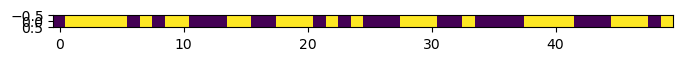

In [9]:
plt.figure(figsize=(8,5))
size = (50,) #A
hid_layer = 20 #B
# layer 모양이 (4,20), (20,2) 이므로 120개의 매개변수가 필요하다 
params = gen_params(size[0],4*hid_layer+hid_layer*2) #C 매개변수 120개 만들기 
grid = init_grid(size=size)
grid_ = grid.clone() #D
print(grid)
plt.imshow(np.expand_dims(grid,0))

##### Listing 9.8

In [10]:
epochs = 200
lr = 0.001 #A
# 각 agent 마다 q가 다르므로 loss들도 모두 다르다 [[],[], ..., []]
losses = [[] for i in range(size[0])] #B

for i in range(epochs):
    for j in range(size[0]): #C  agent 하나씩 처리
        # 왼쪽 이웃, 없으면 맨 오른쪽 
        l = j - 1 if j - 1 >= 0 else size[0]-1 #D
        # 오른쪽 이웃, 없으면 맨 왼쪽 
        r = j + 1 if j + 1 < size[0] else 0 #E
        state_ = grid[[l,r]] #F
        state = joint_state(state_) #G  결합 상태 얻기 
        
        qvals = qfunc(state.float().detach(),params[j],layers=[(4,hid_layer),(hid_layer,2)])
        qmax = torch.argmax(qvals,dim=0).detach().item() #H
        action = int(qmax)
        grid_[j] = action #I grid_:= clone of grid 

        reward = get_reward(state_.detach(),action)
        
        with torch.no_grad(): #J  훈련의 목표값 
            target = qvals.clone()
            target[action] = reward
            
        # gradient method 
        loss = torch.sum(torch.pow(qvals - target,2))
        losses[j].append(loss.detach().numpy())
        loss.backward()
        with torch.no_grad(): #K
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True
        
    with torch.no_grad(): #L  모든 동작을 수행한 후에 grid_를 grid에 복사한다 
        grid.data = grid_.data

##### Visualization of 1D Ising Model

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0], dtype=torch.uint8) tensor(35)


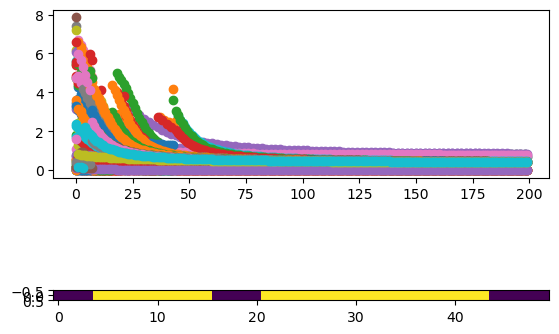

In [11]:
fig,ax = plt.subplots(2,1)
for i in range(size[0]):
    ax[0].scatter(np.arange(len(losses[i])),losses[i])
print(grid,grid.sum())
ax[1].imshow(np.expand_dims(grid,0))

##### Listing 9.9

In [12]:
from collections import deque #A
from random import shuffle #B

# 물리학에선 볼츠만 분포라고 하기도 한다 .
def softmax_policy(qvals,temp=0.9): #C  temp: 온도 매개변수, 높을수록 확률값들의 차이가 작아짐 
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp)) #D  softmax 함수 사용 
    action = torch.multinomial(soft,1) #E  확률분포에서 동작 하나 추출 
    return action

##### Listing 9.10

In [13]:
# 1차원의 벡터에서 좌표 구하기 ex) 100의 원소를 (10,10)으로 만들때  index=57의 좌표는? 
def get_coords(grid,j): #A
    x = int(np.floor(j / grid.shape[0])) #B ex) x=57//10=5
    y = int(j - x * grid.shape[0]) #C  ex) y=57-10*x =7
    return x,y  # (5,7)

def get_reward_2d(action,action_mean): #D  ex) [1,0], [0.25, 0.75]
    r = (action*(action_mean-action/2)).sum()/action.sum() #E  ex) -0.25/1
    return torch.tanh(5 * r) #F ex) tanh(-1.25) ~ -0.8483 

In [14]:
x1 = get_reward_2d(torch.Tensor([1,0]),torch.Tensor([0.25, 0.75]))
x2 = get_reward_2d(torch.Tensor([0,1]),torch.Tensor([0.25, 0.75]))
print(x1,x2)

tensor(-0.8483) tensor(0.8483)


##### Listing 9.11

In [15]:
# j 주변 8개의 좌표에 해당하는 동작벡터의 합을 정규화해서 확률 분포로 만듦 
def mean_action(grid,j):
    x,y = get_coords(grid,j) #A
    action_mean = torch.zeros(2) #B
    for i in [-1,0,1]: #C
        for k in [-1,0,1]:
            if i == k == 0:
                continue
            x_,y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ <  grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_,y_]
            s = get_substate(cur_n) #D
            action_mean += s
    action_mean /= action_mean.sum() #E
    return action_mean

tensor(458)


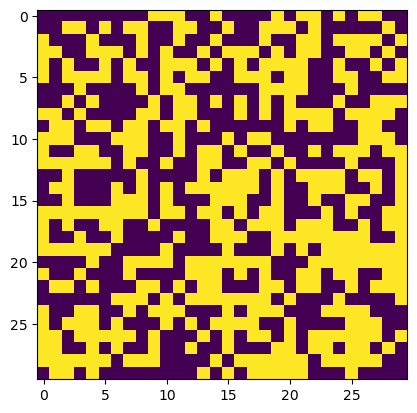

In [17]:
size = (30, 30)
J = np.prod(size) 
hid_layer = 10
layers = [(2,hid_layer),(hid_layer,2)]
# 이번엔 모든 agent가 동일한 최적정책을 사용하므로 매개변수를 1개만 사용 
params = gen_params(1,2*hid_layer+hid_layer*2)
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid)
print(grid.sum())

##### Listing 9.12

In [18]:
epochs = 75
lr = 0.0001
num_iter = 3 #A 무작위성을 제거하기 위한 반복횟수 
# losses = [ [] for i in range(size[0])] #B ex) 여기선 30 
replay_size = 50 #C
replay = deque(maxlen=replay_size) #D
batch_size = 10 #E
gamma = 0.9 #F discouont factor 
losses = [[] for i in range(J)]  # ex) J=30*30=900

for i in range(epochs): 
    act_means = torch.zeros((J,2)) #G  up & down 확률분포기 때문에 [[a,b],[c,b],...,[x,y]] 형태 
    q_next = torch.zeros(J) #H

    for m in range(num_iter): #I  무작위성 희석시키기 위해 좀 반복 
        for j in range(J): #J  알갱이가 900개 
            action_mean = mean_action(grid_,j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(),params[0],layers=layers)
            action = softmax_policy(qvals.detach(),temp=0.5)
            grid__[get_coords(grid_,j)] = action
            q_next[j] = torch.max(qvals).detach()

        grid_.data = grid__.data  # 모든 액션을 취하고 복사 

    grid.data = grid_.data  # 희석시킨 것 까지 완료하고 복사 

    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j],act_means[j]) for j in range(J)])
    exp = (actions,rewards,act_means,q_next) #K
    replay.append(exp)  # 경험목록에 추가 
    shuffle(replay)  # 섞기

    if len(replay) > batch_size: #L 적당히 쌓이면 시작 
        ids = np.random.randint(low=0,high=len(replay),size=batch_size) #M 무작위로 뽑을 난수 생성 
        exps = [replay[idx] for idx in ids]

        for j in range(J):
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()  # act_means
            vs = torch.stack([ex[3][j] for ex in exps]).detach()  # q_next
            qvals = torch.stack([ qfunc(jmeans[h].detach(),params[0],layers=layers) \
                                 for h in range(batch_size)])

            target = qvals.clone().detach()
            target[:,torch.argmax(jacts,dim=1)] = jrewards + gamma * vs  # V_target = r + gamma*V_next 
            loss = torch.sum(torch.pow(qvals - target.detach(),2))
            losses[j].append(loss.item())
            loss.backward()
            
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True

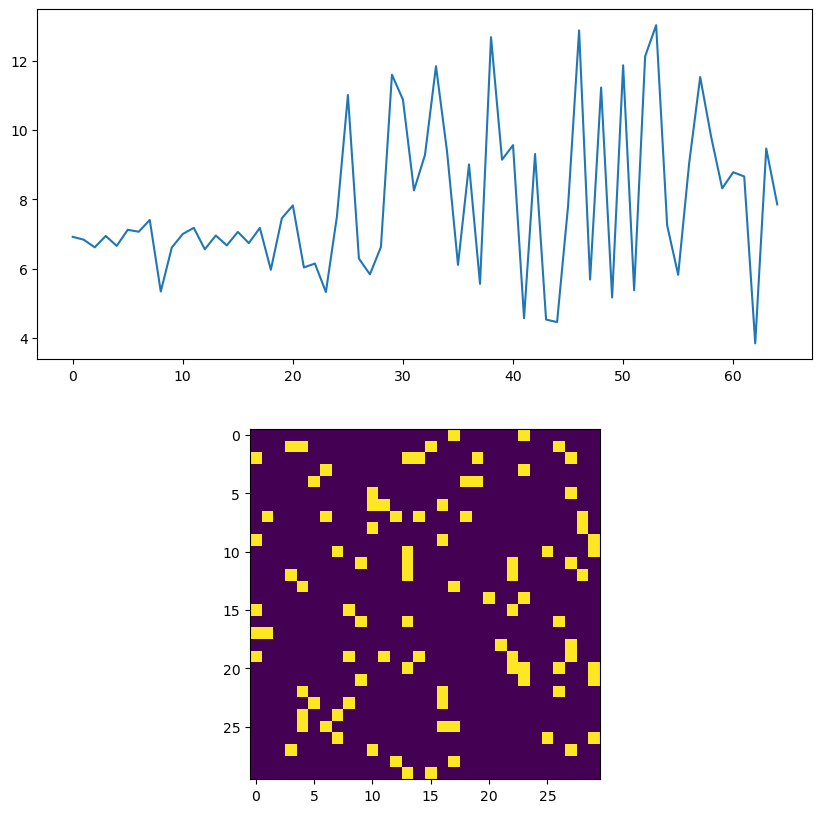

In [19]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,10)
ax[0].plot(np.array(losses).mean(axis=0))
ax[1].imshow(grid)

##### Listing 9.13

In [11]:
import magent
import math
from scipy.spatial.distance import cityblock #A
map_size = 30
env = magent.GridWorld("battle", map_size=map_size) #B
env.set_render_dir("MAgent/build/render") #C
team1, team2 = env.get_handles() #D

##### Listing 9.14

In [20]:
hid_layer = 25
in_size = 359
act_space = 21
layers = [(in_size,hid_layer),(hid_layer,act_space)]
params = gen_params(2,in_size*hid_layer+hid_layer*act_space) #A
map_size = 30
width = height = map_size
n1 = n2 = 16 #B
gap = 1 #C
epochs = 100
replay_size = 70
batch_size = 25


side1 = int(math.sqrt(n1)) * 2
pos1 = []
for x in range(width//2 - gap - side1, width//2 - gap - side1 + side1, 2): #D
    for y in range((height - side1)//2, (height - side1)//2 + side1, 2):
        pos1.append([x, y, 0])

side2 = int(math.sqrt(n2)) * 2
pos2 = []
for x in range(width//2 + gap, width//2 + gap + side2, 2): #E
    for y in range((height - side2)//2, (height - side2)//2 + side2, 2):
        pos2.append([x, y, 0])
        
env.reset()
env.add_agents(team1, method="custom", pos=pos1) #F
env.add_agents(team2, method="custom", pos=pos2)


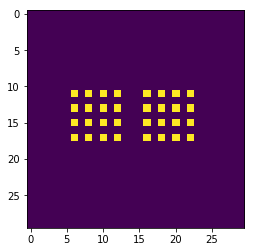

In [21]:
plt.imshow(env.get_global_minimap(30,30)[:,:,:].sum(axis=2))

##### Listing 9.15

In [22]:
def get_neighbors(j,pos_list,r=6): #A
    neighbors = []
    pos_j = pos_list[j]
    for i,pos in enumerate(pos_list):
        if i == j:
            continue
        dist = cityblock(pos,pos_j)
        if dist < r:
            neighbors.append(i)
    return neighbors


In [23]:
get_neighbors(5,env.get_pos(team1))

[0, 1, 2, 4, 6, 7, 8, 9, 10, 13]

##### Listing 9.16

In [25]:
def get_onehot(a,l=21): #A
    x = torch.zeros(21)
    x[a] = 1
    return x

def get_scalar(v): #B
    return torch.argmax(v)

def get_mean_field(j,pos_list,act_list,r=7,l=21): #C
    neighbors = get_neighbors(j,pos_list,r=r) #D
    mean_field = torch.zeros(l)
    for k in neighbors:
        act_ = act_list[k]
        act = get_onehot(act_)
        mean_field += act
    tot = mean_field.sum()
    mean_field = mean_field / tot if tot > 0 else mean_field #E
    return mean_field

##### Listing 9.17

In [33]:
def infer_acts(obs,param,layers,pos_list,acts,act_space=21,num_iter=5,temp=0.5):
    N = acts.shape[0] #A
    mean_fields = torch.zeros(N,act_space)
    acts_ = acts.clone() #B
    qvals = torch.zeros(N,act_space)

    for i in range(num_iter): #C
        for j in range(N): #D
            mean_fields[j] = get_mean_field(j,pos_list,acts_)

        for j in range(N): #E
            state = torch.cat((obs[j].flatten(),mean_fields[j]))
            qs = qfunc(state.detach(),param,layers=layers)
            qvals[j,:] = qs[:]
            acts_[j] = softmax_policy(qs.detach(),temp=temp)
    return acts_, mean_fields, qvals

def init_mean_field(N,act_space=21):
    mean_fields = torch.abs(torch.rand(N,act_space))
    for i in range(mean_fields.shape[0]):
        mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
    return mean_fields

##### Listing 9.18

In [46]:
def train(batch_size,replay,param,layers,J=64,gamma=0.5,lr=0.001):
    ids = np.random.randint(low=0,high=len(replay),size=batch_size)
    exps = [replay[idx] for idx in ids]
    losses = []
    jobs = torch.stack([ex[0] for ex in exps]).detach() #stack
    jacts = torch.stack([ex[1] for ex in exps]).detach()
    jrewards = torch.stack([ex[2] for ex in exps]).detach()
    jmeans = torch.stack([ex[3] for ex in exps]).detach()
    vs = torch.stack([ex[4] for ex in exps]).detach()
    qs = []
    for h in range(batch_size):
        state = torch.cat((jobs[h].flatten(),jmeans[h]))
        qs.append(qfunc(state.detach(),param,layers=layers))
    qvals = torch.stack(qs)
    target = qvals.clone().detach()
    target[:,jacts] = jrewards + gamma * torch.max(vs,dim=1)[0] #20 = 20 + 20
    loss = torch.sum(torch.pow(qvals - target.detach(),2))
    losses.append(loss.detach().item())
    loss.backward()
    #SGD
    with torch.no_grad():
        param = param - lr * param.grad
    param.requires_grad = True
    return np.array(losses).mean()

##### Listing 9.19

In [39]:
N1 = env.get_num(team1) #A
N2 = env.get_num(team2)
step_ct = 0
acts_1 = torch.randint(low=0,high=act_space,size=(N1,)) #B
acts_2 = torch.randint(low=0,high=act_space,size=(N2,))

replay1 = deque(maxlen=replay_size) #C
replay2 = deque(maxlen=replay_size)

qnext1 = torch.zeros(N1) #D
qnext2 = torch.zeros(N2)

act_means1 = init_mean_field(N1,act_space)  #E
act_means2 = init_mean_field(N2,act_space)

rewards1 = torch.zeros(N1) #F
rewards2 = torch.zeros(N2)

losses1 = []
losses2 = []

##### Listing 9.20

In [40]:
def team_step(team,param,acts,layers):
    obs = env.get_observation(team) #A
    ids = env.get_agent_id(team) #B
    obs_small = torch.from_numpy(obs[0][:,:,:,[1,4]]) #C
    agent_pos = env.get_pos(team) #D 
    acts, act_means, qvals = infer_acts(obs_small,\
                                       param,layers,agent_pos,acts) #E
    return acts, act_means, qvals, obs_small, ids

def add_to_replay(replay,obs_small, acts,rewards,act_means,qnext): #F
    for j in range(rewards.shape[0]): #G
        exp = (obs_small[j], acts[j],rewards[j],act_means[j],qnext[j])
        replay.append(exp)
        
    return replay

##### Listing 9.21

In [47]:
for i in range(epochs):
    done = False
    while not done: #A
        acts_1, act_means1, qvals1, obs_small_1, ids_1 = \
            team_step(team1,params[0],acts_1,layers) #B
        env.set_action(team1, acts_1.detach().numpy().astype(np.int32)) #C

        acts_2, act_means2, qvals2, obs_small_2, ids_2 = \
            team_step(team2,params[0],acts_2,layers)
        env.set_action(team2, acts_2.detach().numpy().astype(np.int32))

        done = env.step() #D

        _, _, qnext1, _, ids_1 = team_step(team1,params[0],acts_1,layers) #E
        _, _, qnext2, _, ids_2 = team_step(team2,params[0],acts_2,layers)

        env.render() #F

        rewards1 = torch.from_numpy(env.get_reward(team1)).float() #G
        rewards2 = torch.from_numpy(env.get_reward(team2)).float()
        #
        #
        #
        replay1 = add_to_replay(replay1, obs_small_1, acts_1,rewards1,act_means1,qnext1) #A
        replay2 = add_to_replay(replay2, obs_small_2, acts_2,rewards2,act_means2,qnext2)     
        shuffle(replay1) #B
        shuffle(replay2)
        
        ids_1_ = list(zip(np.arange(ids_1.shape[0]),ids_1)) #C
        ids_2_ = list(zip(np.arange(ids_2.shape[0]),ids_2))
        
        env.clear_dead() #D
        
        ids_1  = env.get_agent_id(team1) #E
        ids_2  = env.get_agent_id(team2)
        
        ids_1_ = [i for (i,j) in ids_1_ if j in ids_1] #F
        ids_2_ = [i for (i,j) in ids_2_ if j in ids_2]
        
        acts_1 = acts_1[ids_1_] #G
        acts_2 = acts_2[ids_2_]
        
        step_ct += 1
        if step_ct > 250:
            break
            
        if len(replay1) > batch_size and len(replay2) > batch_size: #H
            loss1 = train(batch_size,replay1,params[0],layers=layers,J=N1)
            loss2 = train(batch_size,replay2,params[1],layers=layers,J=N1)
            losses1.append(loss1)
            losses2.append(loss2)